In [1]:
import csv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np
from matplotlib.path import Path

import rupworktools as rwt
import math
import json
deg2km = 111.19492664455873
km2deg = 0.008993216059187306

In [2]:
def get_depthkey(dep):
    dpbins = [x for x in range(0,300, 10)]
    fbs = 5
    if dep<20:
        return '20'
    if dep>290:
        dep = 290
    for db in dpbins:
        if (dep>=db-fbs) & (dep<db+fbs):
            return (str(db))
    return None

def get_focmech(dep, faultmod):
    key = get_depthkey(dep)
    return faultmod[key][1]
    

Minimum shallow rupture depth: Hik = 3.1 km, Puy = 1.7 km


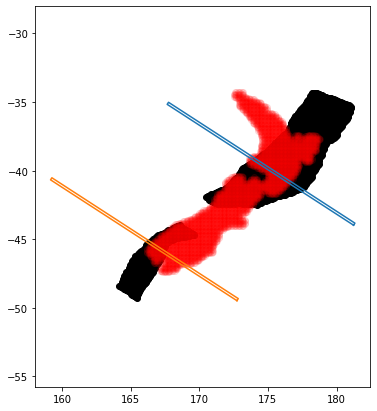

In [3]:
# a quick look at the sites and subduction zones
glon_sites, glat_sites = rwt.get_lonlat('NZ_whole_country_10k.csv')
glon_hik, glat_hik, gdep_hik = rwt.get_grid('hik')
glon_puy, glat_puy, gdep_puy = rwt.get_grid('puy')
print('Minimum shallow rupture depth: Hik = %.1f km, Puy = %.1f km' %(min(gdep_hik), min(gdep_puy)))

fig, ax = plt.subplots(figsize=(6,7))
ax.plot(glon_hik, glat_hik, 'ko')
ax.plot(glon_puy, glat_puy, 'ko')
ax.plot(glon_sites, glat_sites, 'ro', alpha=0.1);
xm,ym = rwt.get_abox(174.5,-39.5, szone='hik')
ax.plot(xm,ym,)
xm,ym = rwt.get_abox(166,-45, szone='puy')
ax.plot(xm,ym,)
ax.axis('equal');

In [7]:
def plot_rupgeoms(szone, ax=None):
    sbox = {'hik': [174, -40], 'puy': [168, -45]}
    maxdepth = {'hik': 220, 'puy': 150}
    shallowstrike = {'hik': 220, 'puy': 30}
    params = {'hL': 900, 'hW': 4,'rothik': -10,'rotpuy':-10,}
    finterp_file = {'hik': '../01subduction-model/finterp/hik_finterp.npy', 
                'puy': '../01subduction-model/finterp/puy_finterp.npy',}

    finterp_slabdeps = np.load('../pyslabgrid/finterp_slabdeps.npy', allow_pickle=True)[()]

    glon, glat, gdep = rwt.get_grid(szone)
    xbs,ybs = rwt.get_abox(sbox[szone][0],sbox[szone][1], szone=szone, params=params)

    IN = rwt.get_inpolygon(glon, glat, (xbs,ybs))
    lon_int, lat_int = np.array(glon)[IN].tolist(), np.array(glat)[IN].tolist()
    IN = rwt.get_inpolygon(glon_sites, glat_sites, (xbs,ybs))
    lon_site, lat_site = np.array(glon_sites)[IN].tolist(), np.array(glat_sites)[IN].tolist()

    finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
    dep_finterp = finterp['depth']
    dep_int = dep_finterp(np.transpose([lon_int,lat_int])).tolist()

    finterp_midslab = finterp_slabdeps[szone]['sheet2']
    dep_midslab = finterp_midslab(np.transpose([lon_int,lat_int])).tolist()

    with open('../09rupture-geometry/slab-faulting2.json') as f:
        faulting_model = json.load(f)

    xlon = lon_int[dep_int.index(min(dep_int))]
    xlat = lat_int[dep_int.index(min(dep_int))]

    #plt.plot(lon_int, lat_int,'o')
    #plt.plot(lon_site, lat_site,'o');
    #plt.plot(xlon, xlat, 'rx', markersize=12);
    #plt.show()

    xdist = []
    for x, y in zip(lon_int, lat_int): 
        dist = math.hypot(x-xlon, y-xlat)
        xdist.append(dist*deg2km)

    tdist = xdist
    # sort the dist according to dep or dist
    xdist, dep_int = zip(*sorted(zip(tdist, dep_int)))
    xdist, dep_midslab = zip(*sorted(zip(tdist, dep_midslab)))

    # randomly select some points
    kps = {'hik': [0,2,5,6,9,12,14,16,18,20], 'puy': [0,2,4,6,8,10]}

    src_z, src_x =[],[]
    for k in kps[szone]:
        src_x.append(xdist[k])
        src_z.append(dep_midslab[k])
    
    site_dist = []
    for x, y in zip(lon_site, lat_site): 
        dist = math.hypot(x-xlon, y-xlat)
        site_dist.append(dist*deg2km)

    #src_dip = []
    #src_strk = []
    #for x in src_z:
    #    focmech = get_focmech(x, faulting_model[szone])
    #    src_dip.append(focmech[1])
    #    src_strk.append(focmech[0])
    
    ax.plot(xdist, dep_int, '--', linewidth=5, label='interface')
    ax.plot(xdist, dep_midslab, '--', linewidth=3, label ='mid-slab')
   
    # source paramters/dimensions for a maximum magnitude = 8.3
    mag = 8.3
    Hseis = 60
    A = rwt.mag2Area(mag)
    src_dip = []
    rupdep = []
    src_dep = []
    src_dipdir = []
    for sz  in src_z:
        focmech = get_focmech(sz, faulting_model[szone])
        W_sei = Hseis/np.sin(np.deg2rad(focmech[1]))
        
        print('W:', W_sei, 'dip:', focmech[1])
        xh = (W_sei/2)*np.sin(np.deg2rad(focmech[1]))
        
        rdep = sz-xh
        if rdep<20:
            rdep = 20
        if sz <20:
            sz = 20
        src_dep.append(sz)
        rupdep.append(rdep)
        src_dip.append(focmech[1])
        #
        strikedev = abs(shallowstrike[szone] -focmech[0])
        if strikedev > 90:
            src_dipdir.append(0)
        else:
            src_dipdir.append(1)
    kount=1
    for x, d, dr, dip, dipdir  in zip(src_x, src_dep,rupdep,src_dip, src_dipdir):
        if dipdir ==1:
            W_sei = Hseis/np.sin(np.deg2rad(dip))
            rx1 = x-(d-dr)/np.tan(np.deg2rad(dip))
            rd1 = dr
            rx2 = rx1+W_sei*np.cos(np.deg2rad(dip))
            rd2 = rd1+W_sei*np.sin(np.deg2rad(dip))
            ax.plot([rx1, rx2], [rd1, rd2], '-', color='brown', linewidth = 3)
        else:
            W_sei = Hseis/np.sin(np.deg2rad(dip))
            rx1 = x+(d-dr)/np.tan(np.deg2rad(dip))
            rd1 = dr
            rx2 = rx1-W_sei*np.cos(np.deg2rad(dip))
            rd2 = rd1+W_sei*np.sin(np.deg2rad(dip))
            if kount==1:
                ax.plot([rx1, rx2], [rd1, rd2], '-', color='brown', linewidth = 3, label='rupture plane')
                kount = 0
            ax.plot([rx1, rx2], [rd1, rd2], '-',  color='brown', linewidth = 3)
        # ax.plot(src_x, rupdep, 'x')
        
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Depth (km)')
    ax.plot(site_dist, [0]*len(site_dist), 'r.', label = 'on-land sites')
   # ax.plot(src_x, src_dep, 'o')
    # xx = [x for x in range(100)]
    #plt.plot(xx, [20]*len(xx), '--')
    #ax.axis('equal')

W: 72.37307691023432 dip: 56.0
W: 72.37307691023432 dip: 56.0
W: 72.37307691023432 dip: 56.0
W: 73.69961467033404 dip: 54.5
W: 67.95420304134237 dip: 62.0
W: 66.20267513774951 dip: 65.0
W: 75.12813948937352 dip: 53.0
W: 72.80438460561884 dip: 55.5
W: 65.18162264431778 dip: 67.0
W: 63.457240871200234 dip: 71.0
W: 63.08773345429603 dip: 72.0
W: 65.93687217281621 dip: 65.5
W: 67.82872532999157 dip: 62.2
W: 69.99800383291982 dip: 59.0
W: 65.6781767103628 dip: 66.0
W: 73.24647532568736 dip: 55.0


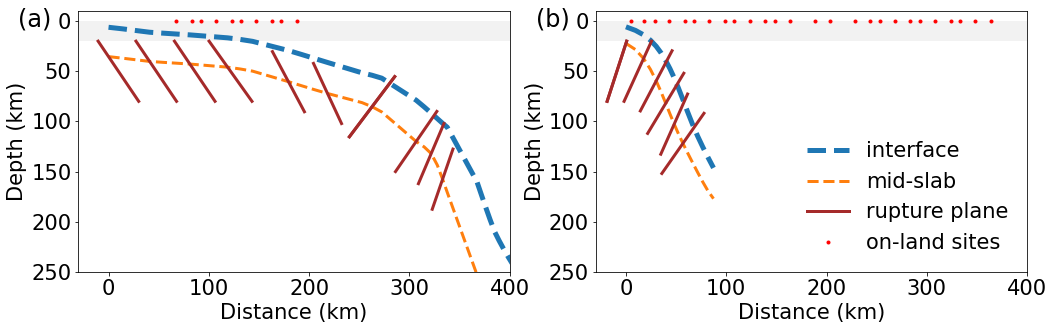

In [8]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,2, figsize=(17,7))
plt.rcParams.update({'font.size': 21})
plot_rupgeoms('hik', ax= ax[0])
ax[0].text(-90,5, '(a)', fontsize=24)
ax[0].set_ylim([-10, 250])
ax[0].set_xlim([-30, 400])
ax[0].add_patch(Rectangle((-40, 0), 450, 20, facecolor='grey', alpha=0.1));
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

plot_rupgeoms('puy', ax=ax[1])
ax[1].text(-90,5, '(b)', fontsize=24)
ax[1].set_ylim([-10, 250])
ax[1].set_xlim([-30, 400])
ax[1].add_patch(Rectangle((-40, 0), 450, 20, facecolor='grey', alpha=0.1));
ax[1].invert_yaxis()
ax[1].legend(frameon=False);
ax[1].set_aspect('equal')

#plt.axes().set_aspect('equal')
plt.savefig('figure12_schema_prelimes', dpi=300, facecolor='w');


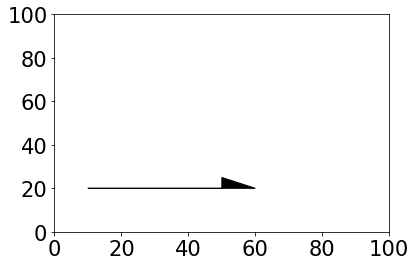

In [6]:
#import matplotlib.pyplsavefig as savefig
plt.arrow(10, 20, 50, 0, length_includes_head=True,shape = 'right',\
                         color='k', head_width=10, head_length=10)
plt.ylim([0, 100])
plt.xlim([0, 100])
plt.savefig('arrowhalf.png', transparent=True)